In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df_stock = pd.read_csv('../data/stock-monthly.csv', dtype={'SICCD': object, 'DLRET': object, 'RET': object})
df_stock['SICCD'] = df_stock['SICCD'].replace('Z', -1).astype(int)
df_stock['DLRET'] = df_stock['DLRET'].replace(['S', 'P', 'T', 'A'], np.nan).astype(float)
df_stock['RET'] = df_stock['RET'].replace('C', 0.).astype(float)

df_acc = pd.read_csv('../data/accounting-monthly.csv')

In [7]:
df_stock = df_stock[(df_stock['date'] >= '1989-01-01') & (df_stock['date'] <= '2022-12-31')]
print(df_stock.shape[0], df_acc.shape[0])
df_merge = pd.merge(
    df_stock,
    df_acc,
    left_on=['PERMNO', 'date'],
    right_on=['PERMNO', "MthCalDt"],
    how='left'
)
print(df_merge.shape[0])

1611728 1835961
1613612


In [14]:
def life_cycle_stg(acc):
    map_oif_2_stg = {(-1, -1, 1): 'Intro', (1, -1, 1): 'Growth', (1, -1, -1): 'Mature',
                     (-1, -1, -1): 'Shakeout', (1, 1, 1): 'Shakeout', (1, 1, -1): 'Shakeout',
                     (-1, 1, 1): 'Decline', (-1, 1, -1): 'Decline'}
    oif = np.sign([acc['oancf'], acc['ivncf'], acc['fincf']])
    # if (np.any(np.isnan(oif))):
    #     return 'Unknown'
    # oif[np.where(oif == 0.)] = 1.
    if np.any(np.isnan(oif)) or np.any(oif == 0):
        return 'Unknown'
    return map_oif_2_stg[tuple(oif)]

df_merge['stg'] = df_merge[['oancf', 'ivncf', 'fincf']].apply(life_cycle_stg, axis=1)

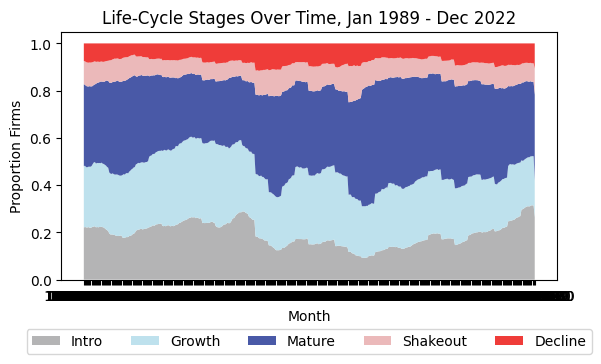

In [19]:
idx_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']
time_series = df_merge['date'].sort_values().unique()
df_frac = pd.DataFrame(time_series, columns=['date'])

count = df_merge[df_merge['stg'] != 'Unknown'].groupby('date').count()
df_frac['Total'] = df_frac['date'].map(count['stg'])
for stage in idx_stg:
    stg_count = df_merge[df_merge['stg'] == stage].groupby('date').count()
    df_frac[stage] = df_frac['date'].map(stg_count['stg'])
    df_frac[stage] = df_frac[stage] / df_frac['Total']
frac_values = [df_frac[stage] for stage in idx_stg]

colors = ['#b4b4b5', '#bee1ed', '#4959a7', '#ebb9ba', '#ef3c39']
plt.stackplot(time_series, frac_values, labels=idx_stg, colors=colors)
plt.title('Life-Cycle Stages Over Time, Jan 1989 - Dec 2022')
plt.xlabel('Month')
plt.ylabel('Proportion Firms')
plt.gca().set_box_aspect(0.5)
plt.legend(ncols=5, loc=[-0.07, -0.3])
plt.show()